In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import math

注意：vocab_size大小是所有词的数量(词汇表的大小)，不是你要输入的词的数量或者一个轮次的词的数量
虽然vocab_size填写的是词的总数量，但是nn.Embedding输出的结果还是(输入词的数量，d_model)

In [2]:
class TokenEmbedding(nn.Embedding):
    # 将输入的词汇表转化为指定维度的Embedding
    def __init__(self,vocab_size,d_model):
        super().__init__(num_embeddings=vocab_size,embedding_dim=d_model,padding_idx=1)
        # 输出大小(input_words_number,d_model)

$PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i / d_{\text{model}}}}\right)$

$PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i / d_{\text{model}}}}\right)$

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__(self,d_model,max_len,device):
        super().__init__()
        self.device=torch.device(device)
        self.encoding=torch.zeros(max_len,d_model,device=self.device)
        self.encoding.requires_grad=False
        pos=torch.arange(0,max_len,device=self.device,dtype=torch.float32)
        pos=pos.unsequeeze(dim=1) # pos的大小为(max_len,1)
        # unsequeezed的作用是在张量的指定位置插入大小为1的维度
        _zi=torch.arange(0,d_model,step=2,dtype=torch.float32,device=self.device)
        self.encoding[:,0::2]=torch.sin(pos/(1000**_zi/d_model))
        self.encoding[:,1::2]=torch.cos(pos/(1000**_zi/d_model))
        # self.encoding的大小为(max_len,d_model)
    def forward(self,x):
        batch_size,seq_len=x.size()
        return self.encoding[:seq_len,:] # return 的大小是(seq_len,d_model)

<tabel>
    <tr>
        <td>
            <img src="https://cdn.lifeiyang.cn//2024_img/202402272105347.png" width="49%">
        </td>
        <td>
            <img src="https://cdn.lifeiyang.cn//2024_img/202402271102635.jpg" width="50%">
        </td>
    </tr>
</table>
$
\begin{equation}\left\{\begin{aligned}
\boldsymbol{q}_i =&\, (\boldsymbol{x}_i + \boldsymbol{p}_i)\boldsymbol{W}_Q \\
\boldsymbol{k}_j =&\, (\boldsymbol{x}_j + \boldsymbol{p}_j)\boldsymbol{W}_K \\
\boldsymbol{v}_j =&\, (\boldsymbol{x}_j + \boldsymbol{p}_j)\boldsymbol{W}_V \\
a_{i,j} =&\, softmax\left(\boldsymbol{q}_i \boldsymbol{k}_j^{\top}\right)\\
\boldsymbol{o}_i =&\, \sum_j a_{i,j}\boldsymbol{v}_j
\end{aligned}\right.\end{equation}
$
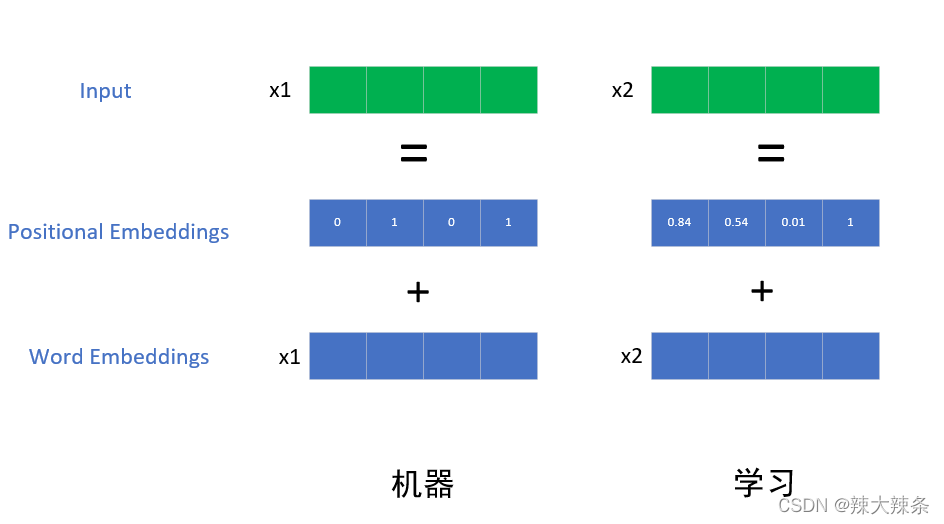
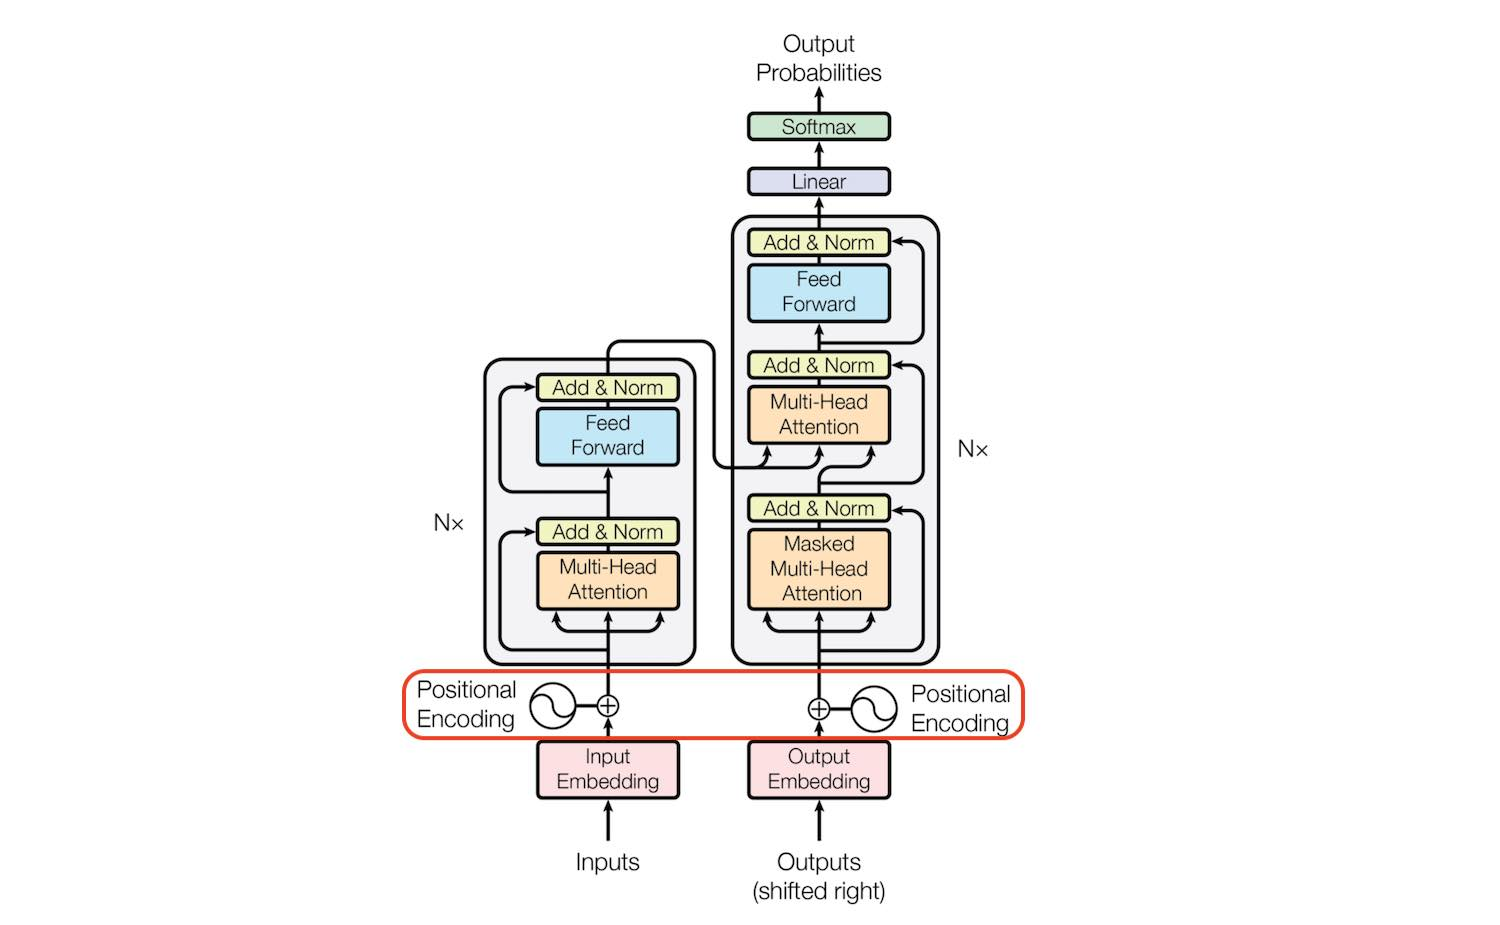

In [ ]:
class TransformerEmbedding(nn.Module):
    def __init__(self,vocab_size,d_model,max_len,drop_prod,device):
        super().__init__()
        self.tok_emb=TokenEmbedding(vocab_size,d_model)
        self.pos_emb=PositionalEmbedding(d_model,max_len,device)
        self.drop_out=nn.Dropout(p=drop_prod)
    def forward(self,x):
        tok_emb=self.tok_emb(x)
        pos_emb=self.pos_emb(x)
        return self.drop_out(tok_emb+pos_emb)